In [1]:
%load_ext autoreload
%autoreload 2
#%matplotlib notebook
# produce V1_allpos, V1_feature, V1_RF

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from patch_square import *

[[-0.03366438  0.39251855]
 [ 0.7301178  -0.61907242]
 [ 0.53065018  0.04644302]
 ...
 [ 0.53894012 -0.30378357]
 [ 0.73966782  0.39173523]
 [-0.0366291  -0.61516929]]


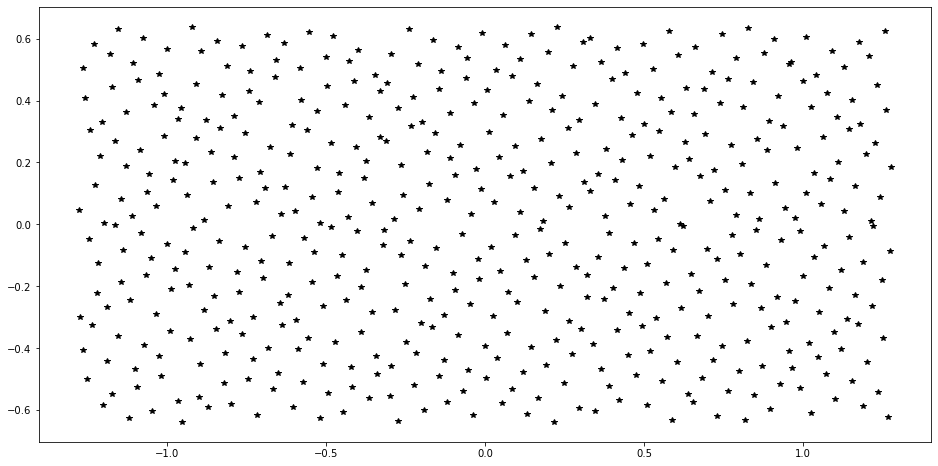

In [9]:
# area per block (1024 neurons) ~ 0.069  𝑚𝑚2 
# model density ~ 14766.156 per  𝑚𝑚2
fp = 'f4'
per_dis = 0.08 #mm
grid_h, grid_w = 16, 32
block_h, block_w = 32, 32
dim = 2
nblock = grid_h*grid_w
blockSize = block_w*block_h
nV1 = nblock*blockSize
pos = np.zeros((nblock, 2, blockSize), dtype = fp)

fig = plt.figure(figsize = [16, 8])
ax = fig.add_subplot(111)
ax.plot(block_center[:,0], block_center[:,1], '*k')

for i in range(nblock):
    pos[i,:,:] = square_pos(np.array([per_dis, per_dis]), block_w, block_h, block_center[i,:])
    ax.plot(block_center[:,0], block_center[:,1], '*')

#for i in range(nblock):
#    get_block_pos

In [14]:
# features

NameError: name 'square_pos' is not defined

In [9]:
pos_filename = 'V1_pos_square_layout_2D.bin'
with open(pos_filename, 'wb') as f:
    np.array([nblock, blockSize, dim]).astype('u4').tofile(f)
    pos.tofile(f)

NameError: name 'square_pos' is not defined